In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import math
import random
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MaskAllButNPixels(object):
    def __init__(self, N):
        self.N = N

    def __call__(self, img):
        # Ensure img is a tensor and squeeze it
        if not isinstance(img, torch.Tensor):
            img = transforms.ToTensor()(img)
        img = img.squeeze()

        mask = torch.zeros_like(img)
        new_img = torch.zeros_like(img)

        non_zero_indices = torch.nonzero(img)
        if len(non_zero_indices) < self.N:
            return torch.stack([mask, img])

        random_indices = torch.randperm(len(non_zero_indices))[:self.N]
        rows, cols = non_zero_indices[random_indices].T

        mask[rows, cols] = 1
        new_img[rows, cols] = img[rows, cols]

        return torch.stack([mask, new_img])

In [ ]:
num_unmasked_pixels = 4
# Test MaskAllButNPixels and visualize results for multiple scenarios
transform = MaskAllButNPixels(num_unmasked_pixels)

# Load the MNIST dataset
mnist_data = datasets.MNIST(
    root='./data', train=True, download=True, transform=None)

# Test scenarios
scenarios = [
    ("Random digit", random.randint(0, len(mnist_data) - 1)),
    # '1' typically has fewer pixels
    ("Digit with few non-zero pixels", mnist_data.targets.tolist().index(1)),
    # '8' typically has more pixels
    ("Digit with many non-zero pixels", mnist_data.targets.tolist().index(8))
]

for scenario_name, sample_idx in scenarios:
    sample_image, label = mnist_data[sample_idx]

    # Apply the transformation
    transformed_image = transform(sample_image)

    # Visualize the original, mask, and masked image
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(sample_image, cmap='gray')
    axes[0].set_title(f'Original Image (Digit: {label})')
    axes[0].axis('off')

    axes[1].imshow(transformed_image[0].squeeze(), cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    axes[2].imshow(transformed_image[1].squeeze(), cmap='gray')
    axes[2].set_title(f'Masked Image ({num_unmasked_pixels} pixels)')
    axes[2].axis('off')

    plt.suptitle(f"Scenario: {scenario_name}")
    plt.tight_layout()
    plt.show()

    # Print the number of non-zero pixels in the masked image
    print(f"Scenario: {scenario_name}")
    print(
        f"Number of non-zero pixels in masked image: {torch.count_nonzero(transformed_image[1])}")
    print(
        f"Total non-zero pixels in original image: {torch.count_nonzero(transforms.ToTensor()(sample_image))}")
    print()

# Test edge case: image with fewer non-zero pixels than num_unmasked_pixels
edge_case_image = torch.zeros((28, 28))
edge_case_image[14, 14] = 1  # Single pixel in the center
edge_case_transformed = transform(transforms.ToPILImage()(edge_case_image))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(edge_case_image, cmap='gray')
axes[0].set_title('Edge Case: Single Pixel Image')
axes[0].axis('off')

axes[1].imshow(edge_case_transformed[0].squeeze(), cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')

axes[2].imshow(edge_case_transformed[1].squeeze(), cmap='gray')
axes[2].set_title(f'Masked Image ({num_unmasked_pixels} pixels)')
axes[2].axis('off')

plt.suptitle("Edge Case: Fewer non-zero pixels than num_unmasked_pixels")
plt.tight_layout()
plt.show()

print("Edge Case: Single Pixel Image")
print(
    f"Number of non-zero pixels in masked image: {torch.count_nonzero(edge_case_transformed[1])}")
print(
    f"Total non-zero pixels in original image: {torch.count_nonzero(edge_case_image)}")

"
Concretely, the judge is trained to classify MNIST from 6 (resp. 4) nonzero pixels, with the pixels
chosen at random at training time. The judge receives two input feature planes:
1. A {0, 1} mask of which pixels were revealed
2. The value of the revealed pixels (with zeros elsewhere)

We used the architecture from the TensorFlow MNIST layers tutorial;
the only difference is the input. We train the judges using:
- Optimizer: Adam
- Learning rate: 10^-4
- Batches: 30k (resp. 50k)
- Batch size: 128 samples

Accuracy achieved:
- 6 pixels: 59.4%
- 4 pixels: 48.2%
"

https://web.archive.org/web/20180516102820/https://www.tensorflow.org/tutorials/layers#building_the_cnn_mnist_classifier

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        # 1. Convolutional Layer #1: Applies 32 5x5 filters (extracting 5x5-pixel subregions), with ReLU activation function
        x = torch.relu(self.conv1(x))
        # 2. Pooling Layer #1: Performs max pooling with a 2x2 filter and stride of 2 (which specifies that pooled regions do not overlap)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # 3. Convolutional Layer #2: Applies 64 5x5 filters, with ReLU activation function
        x = torch.relu(self.conv2(x))
        # 4. Pooling Layer #2: Again, performs max pooling with a 2x2 filter and stride of 2
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 7 * 7)
        # 5. Dense Layer #1: 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 that any given element will be dropped during training)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        # 6. Dense Layer #2 (Logits Layer): 10 neurons, one for each digit target class (0–9).
        x = self.fc2(x)
        return x

In [ ]:
# Define hyperparameters
learning_rate = 1e-4
batch_size = 128
# num_epochs = 64  # 60,000 samples / 128 ~ 469 batches per epoch * 64 epocs = 30,016 (30K for 6-pixel)
# 60,000 samples / 128 ~ 469 batches per epoch * 107 epocs = 50,183 (50K for 4-pixel)
num_epochs = 107

# Set number of pixels
num_pixels = 4  # Change to 4 for the 4-pixel version

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    MaskAllButNPixels(num_pixels)
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_batches = len(train_loader)
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print statistics every epoch
    elapsed_time = time.time() - start_time
    estimated_total_time = elapsed_time * num_epochs / (epoch + 1)
    remaining_time = estimated_total_time - elapsed_time

    print(
        f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / total_batches:.3f}')
    print(f'Estimated time remaining: {remaining_time/60:.2f} minutes')
    running_loss = 0.0

print('Finished Training')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

# Save the model
torch.save(model.state_dict(), f'mnist_judge_{num_pixels}pixels.pth')
print(f'Model saved as mnist_judge_{num_pixels}pixels.pth')

In [ ]:
# Create error matrix
error_matrix = torch.zeros(10, 10)
total_per_class = torch.zeros(10)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            if t != p:  # Only count errors
                error_matrix[t.long(), p.long()] += 1
            total_per_class[t.long()] += 1

# Convert to percentages of total inputs
error_matrix_percent = error_matrix / len(test_dataset) * 100

# Create heatmap
plt.figure(figsize=(12, 10))
cmap = plt.cm.jet
cmap.set_bad('black')  # Set the color for masked values to black

masked_error_matrix = np.ma.array(
    error_matrix_percent.numpy(), mask=np.eye(10))  # Mask diagonal
im = plt.imshow(masked_error_matrix, cmap=cmap, vmin=0, vmax=2)

# Create colorbar
cbar = plt.colorbar(im)
cbar.set_label('Percentage of total inputs', rotation=270, labelpad=15)

# Add text annotations
for i in range(10):
    for j in range(10):
        if i != j:  # Skip diagonal elements
            text = plt.text(j, i, f'{error_matrix_percent[i, j]:.2f}%',
                            ha="center", va="center", color="white" if error_matrix_percent[i, j] < 1 else "black")

plt.title(f'Error Matrix for {num_pixels}-pixel MNIST Judge')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()

In [ ]:
# Create error matrix
error_matrix = torch.zeros(10, 10)
total_per_class = torch.zeros(10)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            if t != p:  # Only count errors
                error_matrix[t.long(), p.long()] += 1
            total_per_class[t.long()] += 1

# Convert to percentages of total inputs
error_matrix_percent = error_matrix / len(test_dataset) * 100

# Create heatmap
plt.figure(figsize=(12, 10))
cmap = plt.cm.jet
cmap.set_bad('black')  # Set the color for masked values to black

masked_error_matrix = np.ma.array(
    error_matrix_percent.numpy(), mask=np.eye(10))  # Mask diagonal
im = plt.imshow(masked_error_matrix, cmap=cmap, vmin=0, vmax=2)

# Create colorbar
cbar = plt.colorbar(im)
cbar.set_label('Percentage of total inputs', rotation=270, labelpad=15)

# Add text annotations
for i in range(10):
    for j in range(10):
        if i != j:  # Skip diagonal elements
            text = plt.text(j, i, f'{error_matrix_percent[i, j]:.2f}%',
                            ha="center", va="center", color="white" if error_matrix_percent[i, j] < 1 else "black")

plt.title(f'Error Matrix for {num_pixels}-pixel MNIST Judge')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()
plt.show

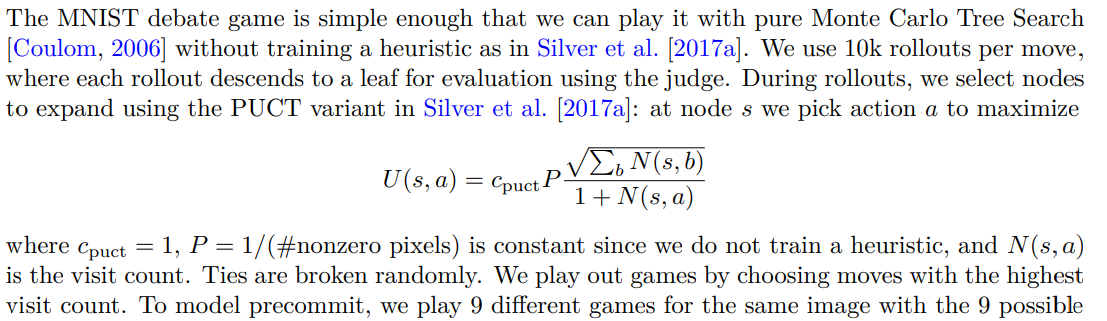

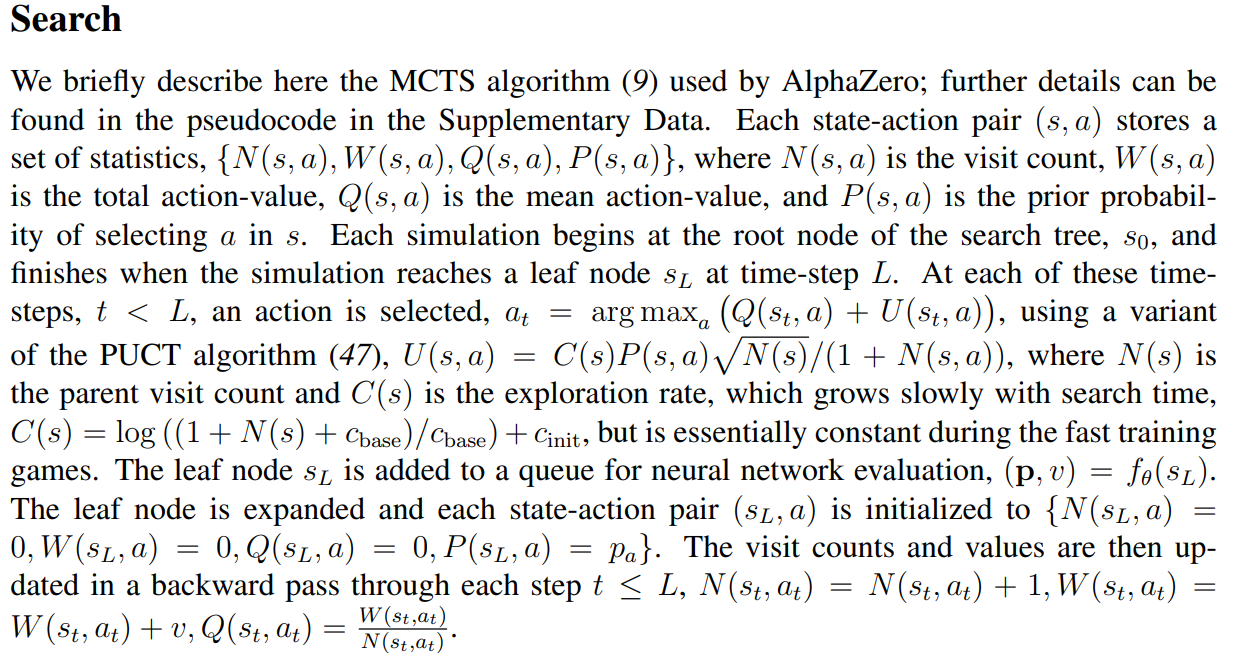

In [ ]:
class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = {}  # Action -> Node
        self.visit_count_n = 0
        self.value_sum_w = 0
        self.mean_value_q = 0
        self.prior_p = 1/len(state.get_legal_actions())

    def update(self, value):
        self.visit_count_n += 1
        self.value_sum_w += value
        self.mean_value_q = self.value_sum_w / self.visit_count_n

    def get_root(self):
        node = self
        while node.parent:
            node = node.parent
        return node

    def is_leaf(self):
        return len(self.children) == 0


class MCTS:
    def __init__(self, judge, num_rollouts=10_000, cpuct=1):
        self.judge = judge
        self.num_rollouts = num_rollouts
        self.cpuct = cpuct

    def search(self, root_state):
        self.root = Node(root_state)
        for rollout in range(1, self.num_rollouts+1):
            if rollout % 1000 == 0 or rollout == 1:
                print(f"Rollout {rollout}/{self.num_rollouts}")
            cur_node = self.root
            cur_state = root_state.clone()
            # Selection phase: traverse the tree to find a leaf node
            cur_node = self.select(cur_node, cur_state)
            # Expansion phase: expand the leaf node by adding its children
            cur_node = self.expand(cur_node, cur_state)
            # Simulation phase: simulate a random play-out from the expanded node
            reward = self.simulate(cur_state)
            # Backpropagation phase: propagate the simulation result up the tree
            self.backpropagate(cur_node, reward)

    def select(self, node, state):
        while not node.is_leaf():
            best_score = -float('inf')
            best_action = None
            best_children = []
            for action, child in node.children.items():
                # Calculate the UCB score for each child
                q = child.mean_value_q
                u = self.cpuct * child.prior_p * \
                    np.sqrt(node.visit_count_n) / (1 + child.visit_count_n)
                score = q + u

                if score > best_score:
                    best_score = score
                    best_action = action
                    best_children = [child]
                elif score == best_score:
                    best_children.append(child)

            if not best_children:
                break  # No children to select

            # Randomly select among the best children to handle ties
            chosen_child = random.choice(best_children)
            chosen_action = None
            # Find the action that leads to the chosen child
            for action, child in node.children.items():
                if child == chosen_child:
                    chosen_action = action
                    break

            # Apply the action to the state to get to the child state
            state = state.apply_action(chosen_action)
            node = chosen_child

        return node

    def expand(self, node, state):
        """
        Expand the node by adding all possible child nodes.
        """
        if node.is_leaf():
            legal_actions = state.get_legal_actions()
            for action in legal_actions:
                next_state = state.apply_action(action)
                node.children[action] = Node(next_state, parent=node)
        return node

    def simulate(self, state):
        """
        Perform a simulation (rollout) from the given state to a terminal state.
        Returns the reward for the simulation.
        """
        current_state = state.clone()
        while not current_state.is_terminal():
            legal_actions = current_state.get_legal_actions()
            action = random.choice(legal_actions)  # Randomly select an action
            current_state = current_state.apply_action(action)
        return self.judge.evaluate(current_state)

    def backpropagate(self, node, reward):
        """
        Propagate the simulation result up the tree, updating visit counts and value sums.
        """
        while node is not None:
            node.update(reward)
            node = node.parent

    def best_action(self, node):
        """
        Select the action with the highest visit count from the root node.
        """
        best_visits = -1
        best_action = None
        for action, child in node.children.items():
            if child.visit_count_n > best_visits:
                best_visits = child.visit_count_n
                best_action = action
        return best_action

In [ ]:
class DebateState:
    def __init__(self, image, label, num_pixels_to_reveal=6):
        """
        Initialize the DebateState with the given image, label, and number of pixels to reveal.

        Args:
            image (torch.Tensor): The true image tensor.
            label (int): The true label of the image.
            num_pixels_to_reveal (int, optional): The total number of pixels to reveal in the game. Defaults to 6.
        """
        self.image = image
        self.label = label
        self.mask = torch.zeros_like(image)
        self.num_pixels_to_reveal = num_pixels_to_reveal
        self.current_player = 0  # Player 0 starts

    def is_terminal(self):
        """
        Check if the game has reached a terminal state.

        Returns:
            bool: True if the number of revealed pixels meets or exceeds the limit, False otherwise.
        """
        return torch.sum(self.mask).item() >= self.num_pixels_to_reveal

    def get_legal_actions(self):
        """
        Get all legal actions (pixels that have not yet been revealed).

        Returns:
            List[int]: A list of linear indices representing unrevealed pixels.
        """
        return (self.mask.view(-1) == 0).nonzero(as_tuple=True)[0].tolist()

    def apply_action(self, action):
        """
        Apply an action by revealing the specified pixel.

        Args:
            action (int): The linear index of the pixel to reveal.

        Returns:
            DebateState: A new state with the action applied.
        """
        if self.mask.view(-1)[action] == 1:
            raise ValueError(
                f"Action {action} is invalid because the pixel is already revealed.")

        new_state = self.clone()
        new_state.mask.view(-1)[action] = 1
        new_state.current_player = 1 - self.current_player  # Switch player
        return new_state

    def clone(self):
        """
        Create a deep copy of the current state.

        Returns:
            DebateState: A cloned copy of the current state.
        """
        return DebateState(
            image=self.image.clone(),
            label=self.label,
            num_pixels_to_reveal=self.num_pixels_to_reveal
        )._copy_attributes(self)

    def _copy_attributes(self, other):
        """
        Helper method to copy attributes from another state.

        Args:
            other (DebateState): The state to copy attributes from.

        Returns:
            DebateState: The current state with copied attributes.
        """
        self.mask = other.mask.clone()
        self.current_player = other.current_player
        return self

    def get_current_player(self):
        """
        Get the current player.

        Returns:
            int: The current player's identifier (0 or 1).
        """
        return self.current_player

    def __repr__(self):
        """
        Return a string representation of the DebateState.

        Returns:
            str: String representation of the state.
        """
        return (f"DebateState(current_player={self.current_player}, "
                f"pixels_revealed={torch.sum(self.mask).item()}/{self.num_pixels_to_reveal})")

In [ ]:
class Judge:
    def __init__(self, model):
        self.model = model

    def evaluate(self, state):
        """
        Evaluate the state using the model.

        Args:
            state (DebateState): The current state of the game.

        Returns:
            float: The evaluation score of the state.
        """
        observation = state.get_observation()
        with torch.no_grad():
            output = self.model(observation)
        probabilities = F.softmax(output, dim=1)
        true_label_prob = probabilities[0, state.label].item()
        return true_label_prob if state.current_player == 0 else 1 - true_label_prob

In [ ]:
class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = {}  # Action -> Node
        self.visit_count_n = 0
        self.value_sum_w = 0
        self.mean_value_q = 0
        self.prior_p = 1/len(state.get_legal_actions())

    def update(self, value):
        self.visit_count_n += 1
        self.value_sum_w += value
        self.mean_value_q = self.value_sum_w / self.visit_count_n


class MCTS:
    def __init__(self, judge, num_rollouts=10_000, cpuct=1):
        self.judge = judge
        self.num_rollouts = num_rollouts
        self.cpuct = cpuct

    def search(self, root_state):
        root = Node(root_state)
        for i in range(1, self.num_rollouts + 1):
            if i % 1000 == 0 or i == 1:
                print(f"Rollout {i}/{self.num_rollouts}")
            node = root
            state = root_state.clone()

            # Selection
            depth = 0
            while node.children and not state.is_terminal():
                action = self.select_action(node)
                state.apply_action(action)
                node = node.children[action]
                depth += 1
                if depth > 100:
                    print("Selection exceeded 100 steps. Breaking.")
                    break

            # Expansion
            if not state.is_terminal():
                self.expand(node, state)

            # Simulation
            sim_depth = 0
            while not state.is_terminal():
                legal_actions = state.get_legal_actions()
                if not legal_actions:
                    break
                action = random.choice(legal_actions)
                state.apply_action(action)
                sim_depth += 1
                if sim_depth > 100:
                    print("Simulation exceeded 100 steps. Breaking.")
                    break

            # Evaluation
            value = self.judge.evaluate(state)

            # Backpropagation
            while node is not None:
                node.update(value)
                node = node.parent

            # Debug: Print all children actions and their visit counts
            print("Root Children Actions and Visit Counts:")
            for action, node in root.children.items():
                print(f"Action: {action}, Visit Count: {node.visit_count_n}")
            best_action = max(root.children.items(),
                              key=lambda x: x[1].visit_count_n)[0]
            print(f"Selected Best Action: {best_action}")
            return best_action

    def puct_u(self, parent, child):
        return self.cpuct * child.prior_p * np.sqrt(parent.visit_count_n) / (1 + child.visit_count_n)

    def select_action(self, node):  # puct algorithm
        return max(node.children.items(),
                   key=lambda x: x[1].mean_value_q + self.puct_u(node, x[1]) +
                   (0.001 * random.random()))  # small random number for tie-breaking

    def expand(self, node, state):
        legal_actions = state.get_legal_actions()
        print(f"Legal actions: {legal_actions}")  # Debugging line
        for action in legal_actions:
            if action not in node.children:
                new_state = state.clone()
                try:
                    new_state.apply_action(action)
                except ValueError as e:
                    # Debugging line
                    print(f"Error applying action {action}: {e}")
                    continue
                new_node = Node(new_state, parent=node)
                new_node.prior_p = 1 / len(legal_actions)  # uniform prior
                node.children[action] = new_node
                return
        print("No valid actions to expand")  # Debugging line


class DebateState:
    def __init__(self, image, label, num_pixels_to_reveal=6):
        # Ensure image is 2D
        if image.dim() > 2:
            self.image = image.squeeze()  # Remove any singleton dimensions
        else:
            self.image = image
        self.label = label
        self.mask = torch.zeros_like(self.image)  # Mask of revealed pixels
        self.num_pixels_to_reveal = num_pixels_to_reveal
        self.current_player = 0  # 0 for first player, 1 for second player

    def is_terminal(self):
        # The game ends when the number of revealed pixels equals num_pixels_to_reveal
        return torch.sum(self.mask) >= self.num_pixels_to_reveal

    def value(self):
        return

    def get_legal_actions(self):
        """
        Legal actions are the coordinates of unrevealed non-zero pixels.
        Returns:
            List of tuples representing (x, y) coordinates.
        """
        unrevealed = (self.mask == 0) & (self.image != 0)
        nonzero = unrevealed.nonzero(as_tuple=False)  # Shape: [N, 2]

        # Extract coordinates correctly
        actions = [tuple(coord.tolist()) for coord in nonzero]

        return actions

    def apply_action(self, action):
        # Reveal the pixel at the given coordinates
        if not isinstance(action, tuple) or len(action) != 2:
            raise ValueError(
                f"Invalid action format: {action}. Expected a tuple of two integers.")
        x, y = action
        if not isinstance(x, int) or not isinstance(y, int):
            raise ValueError(
                f"Invalid action coordinates: {action}. Both x and y should be integers.")
        self.mask[x, y] = 1
        # Switch to the other player
        self.current_player = 1 - self.current_player

    def clone(self):
        new_state = DebateState(
            self.image.clone(), self.label, self.num_pixels_to_reveal)
        new_state.mask = self.mask.clone()
        new_state.current_player = self.current_player
        return new_state

    def get_observation(self):
        # Return the masked image (for the judge to evaluate)
        return torch.stack([self.mask, self.image * self.mask])


class Judge:
    def __init__(self, model):
        self.model = model

    def evaluate(self, state):
        # Get the observation from the state
        observation = state.get_observation().unsqueeze(0)  # Add batch dimension

        # Pass the observation through the model
        with torch.no_grad():
            output = self.model(observation)

        # Get the probability for the true label
        probabilities = F.softmax(output, dim=1)
        true_label_prob = probabilities[0, state.label].item()

        # Return the probability as the value
        # Note: You might want to adjust this based on the current player
        return true_label_prob if state.current_player == 0 else 1 - true_label_prob

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = Net().to(device)
model.load_state_dict(torch.load('mnist_judge_6pixels.pth'))
model.eval()  # Set the model to evaluation mode
judge = Judge(model)

In [ ]:
def visualize_state(state: DebateState, title: str = "Current State"):
    """
    Visualizes the current state of the debate game.

    Args:
        state (DebateState): The current state to visualize.
        title (str): Title of the plot.
    """
    masked_image = state.get_observation()[1].squeeze().numpy()
    mask = state.mask.squeeze().numpy()
    image = state.image.squeeze().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    # Masked Image
    axes[2].imshow(masked_image, cmap='gray')
    axes[2].set_title('Masked Image')
    axes[2].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def play_debate_game(image, label, mcts, num_pixels=6, visualize=True):
    """
    Plays a single debate game.

    Args:
        image (torch.Tensor): The MNIST image tensor.
        label (int): The true label of the image.
        mcts (MCTS): The MCTS instance.
        num_pixels (int): Number of pixels to reveal.
        visualize (bool): Whether to visualize each step.

    Returns:
        float: Final judge evaluation value.
    """
    initial_state = DebateState(image, label, num_pixels_to_reveal=num_pixels)

    if visualize:
        visualize_state(initial_state, title="Initial State")

    turn = 0
    while not initial_state.is_terminal():
        print(
            f"Turn {turn + 1}, Revealed pixels: {initial_state.mask.sum().item()}/{num_pixels}")

        # MCTS decides on the best action
        action = mcts.search(initial_state)
        if action is None:
            print("No valid actions available. Ending game.")
            break
        initial_state.apply_action(action)
        print(f"Player {turn % 2 + 1} revealed pixel at {action}")

        if visualize:
            visualize_state(initial_state, title=f"After Turn {turn + 1}")

        turn += 1

        if turn > 100:  # Safety check to prevent infinite loops
            print("Game exceeded 100 turns. Ending game.")
            break

    final_value = judge.evaluate(initial_state)
    return final_value

In [ ]:
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create an MCTS instance
# You can adjust the number of rollouts
mcts = MCTS(judge, num_rollouts=10_000)
# Assuming mcts and judge are already initialized
index = torch.randint(len(test_dataset), (1,)).item()
image, label = test_dataset[index]

print(f"Playing game with image of label: {label}")
final_value = play_debate_game(image, label, mcts, visualize=True)

print(f"Final judge evaluation: {final_value:.4f}")
print(
    f"Winner: {'Player 1 (Honest)' if final_value > 0.5 else 'Player 2 (Misleading)'}")

In [ ]:
import networkx as nx


def visualize_mcts_tree(root: Node, max_depth: int = 3):
    """
    Visualizes the MCTS tree up to a specified depth.

    Args:
        root (Node): The root node of the MCTS tree.
        max_depth (int): Maximum depth to visualize.
    """
    G = nx.DiGraph()

    def add_edges(node, depth):
        if depth > max_depth:
            return
        for action, child in node.children.items():
            G.add_edge(str(node.state.mask.sum().item()), str(
                child.state.mask.sum().item()) + f" Action: {action}")
            add_edges(child, depth + 1)

    add_edges(root, 0)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500,
            node_color='lightblue', arrows=True)
    plt.title(f"MCTS Tree Visualization up to Depth {max_depth}")

In [ ]:
# Perform a small number of rollouts for visualization
mcts = MCTS(judge, num_rollouts=1)
initial_state = DebateState(image, label, num_pixels_to_reveal=6)
mcts.search(initial_state)

# Visualize the tree
visualize_mcts_tree(mcts.root, max_depth=3)

In [ ]:
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create an MCTS instance
mcts = MCTS(judge, num_rollouts=1)  # You can adjust the number of rollouts

# Play multiple debate games
num_games = 10
for game in range(num_games):
    # Randomly select an image from the test set
    index = torch.randint(len(test_dataset), (1,)).item()
    image, label = test_dataset[index]

    print(f"\nGame {game + 1}")
    print(f"True label: {label}")

    final_value = play_debate_game(image, label, mcts)

    print(f"Final judge evaluation: {final_value:.4f}")
    print(
        f"Winner: {'Player 1 (Honest)' if final_value > 0.5 else 'Player 2 (Misleading)'}")

In [ ]:
import random


class SimpleState:
    def __init__(self, moves_left=10):
        self.moves_left = moves_left

    def is_terminal(self):
        return self.moves_left == 0

    def get_legal_actions(self):
        return ['A', 'B'] if not self.is_terminal() else []

    def apply_action(self, action):
        self.moves_left -= 1

    def clone(self):
        return SimpleState(self.moves_left)


class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = {}
        self.visit_count = 0
        self.value_sum = 0


class SimpleMCTS:
    def __init__(self, num_rollouts=100):
        self.num_rollouts = num_rollouts

    def search(self, root_state):
        root = Node(root_state)
        for _ in range(self.num_rollouts):
            node = root
            state = root_state.clone()

            # Selection and Expansion
            while not state.is_terminal():
                if len(node.children) < len(state.get_legal_actions()):
                    self.expand(node, state)
                    break
                action = random.choice(list(node.children.keys()))
                node = node.children[action]
                state.apply_action(action)

            # Simulation
            while not state.is_terminal():
                action = random.choice(state.get_legal_actions())
                state.apply_action(action)

            # Backpropagation
            value = random.random()  # Dummy value
            while node is not None:
                node.visit_count += 1
                node.value_sum += value
                node = node.parent

        return max(root.children, key=lambda a: root.children[a].visit_count)

    def expand(self, node, state):
        for action in state.get_legal_actions():
            if action not in node.children:
                new_state = state.clone()
                new_state.apply_action(action)
                node.children[action] = Node(new_state, parent=node)
                return


# Test the simple MCTS
mcts = SimpleMCTS()
initial_state = SimpleState()
best_action = mcts.search(initial_state)
print(f"Best action: {best_action}")

In [ ]:
from mcts import mcts

In [ ]:
mcts??

In [ ]:
import random
import matplotlib.pyplot as plt
import networkx as nx


class SimpleDebateState:
    def __init__(self, num_pixels=6):
        self.num_pixels = num_pixels
        self.revealed_pixels = 0
        self.current_player = 0  # 0 for first player, 1 for second player

    def is_terminal(self):
        return self.revealed_pixels >= self.num_pixels

    def get_legal_actions(self):
        return list(range(28*28))  # Simplified: all pixels are legal

    def apply_action(self, action):
        self.revealed_pixels += 1
        self.current_player = 1 - self.current_player

    def clone(self):
        new_state = SimpleDebateState(self.num_pixels)
        new_state.revealed_pixels = self.revealed_pixels
        new_state.current_player = self.current_player
        return new_state


class Node:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = {}
        self.visits = 0
        self.value = 0
        self.root = self.get_root()

    def get_root(self):
        node = self
        while node.parent:
            node = node.parent
        return node


class SimpleMCTS:
    def __init__(self, num_rollouts=100):
        self.num_rollouts = num_rollouts

    def search(self, root_state):
        self.root = Node(root_state)
        for i in range(self.num_rollouts):
            node = self.select(self.root)
            value = self.simulate(node.state)
            self.backpropagate(node, value)
            if i % 10 == 0:
                print(
                    f"Rollout {i}: Selected node with {node.state.revealed_pixels} revealed pixels")

        return self.best_action(self.root)

    def select(self, node):
        while not node.state.is_terminal():
            if len(node.children) < len(node.state.get_legal_actions()):
                return self.expand(node)
            else:
                node = self.best_child(node)
        return node

    def expand(self, node):
        actions = node.state.get_legal_actions()
        for action in actions:
            if action not in node.children:
                new_state = node.state.clone()
                new_state.apply_action(action)
                new_node = Node(new_state, parent=node, action=action)
                node.children[action] = new_node
                return new_node
        return node

    def simulate(self, state):
        while not state.is_terminal():
            action = random.choice(state.get_legal_actions())
            state.apply_action(action)
        return random.random()  # Simplified: return random value

    def backpropagate(self, node, value):
        while node is not None:
            node.visits += 1
            node.value += value
            node = node.parent

    def best_child(self, node, c_param=1.4):
        choices = [(child.value / child.visits) + c_param * ((2 * node.visits / child.visits) ** 0.5)
                   for action, child in node.children.items()]
        return node.children[list(node.children.keys())[choices.index(max(choices))]]

    def best_action(self, node):
        return max(node.children.items(), key=lambda x: x[1].visits)[0]


def visualize_mcts_tree(root, max_depth=3):
    G = nx.DiGraph()

    def add_edges(node, depth):
        if depth > max_depth:
            return
        for action, child in node.children.items():
            G.add_edge(f"{node.state.revealed_pixels}",
                       f"{child.state.revealed_pixels}\n{action}")
            add_edges(child, depth + 1)

    add_edges(root, 0)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000,
            node_color='lightblue', arrows=True)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    plt.title(f"MCTS Tree Visualization up to Depth {max_depth}")
    plt.show()


# Test the simple MCTS
mcts = SimpleMCTS(num_rollouts=100)
initial_state = SimpleDebateState()
best_action = mcts.search(initial_state)
print(f"Best action: {best_action}")

# Visualize the MCTS tree
visualize_mcts_tree(mcts.root, max_depth=1)

In [ ]:
import math
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tree_search import DebateState, Judge, MCTS
import torch
import importlib
import tree_search
importlib.reload(tree_search)


def visualize_state(state, title="Current State"):
    """
    Visualize the current state by displaying the masked image and mask.

    Args:
        state (DebateState): The current game state.
        title (str): Title for the plot.
    """
    masked_image = (
        state.image * state.mask).squeeze().cpu().numpy()  # Masked image
    mask = state.mask.squeeze().cpu().numpy()  # Mask

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Display Mask
    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title('Mask')
    axes[0].axis('off')

    # Display Masked Image
    axes[1].imshow(masked_image, cmap='gray')
    axes[1].set_title('Masked Image')
    axes[1].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def play_game(model, test_dataset, index, num_pixels=6, num_rollouts=1000, visualize=True):
    """
    Play a single game of the debate game.

    Args:
        model (nn.Module): The trained Net model.
        test_dataset (Dataset): The MNIST test dataset.
        index (int): Index of the test image to use.
        num_pixels (int): Number of pixels to reveal.
        num_rollouts (int): Number of MCTS rollouts.
        visualize (bool): Whether to visualize each step.
    """
    # Initialize Judge and MCTS
    judge = Judge(model)
    mcts = MCTS(judge=judge, num_rollouts=num_rollouts)

    # Get the image and label
    image, label = test_dataset[index]
    image = image.to(device)
    label = label

    # Initialize game state
    initial_state = DebateState(
        image=image, label=label, num_pixels_to_reveal=num_pixels)

    if visualize:
        visualize_state(initial_state, title="Initial State")

    current_state = initial_state
    turn = 0

    while not current_state.is_terminal():
        if visualize:
            print(
                f"Turn {turn + 1}: Player {current_state.current_player + 1}'s move")

        # MCTS selects the best action
        mcts.search(current_state)  # Perform MCTS rollouts
        action = mcts.best_action(mcts.root)  # Retrieve the best action

        if action is None:
            print("No valid actions available. Ending game.")
            break

        # Apply the action
        try:
            current_state = current_state.apply_action(action)
            print(f"Player {turn + 1} revealed pixel at index {action}")
        except ValueError as e:
            print(f"Invalid action: {e}")
            break

        if visualize:
            visualize_state(current_state, title=f"After Turn {turn + 1}")

        turn += 1

    # Final evaluation
    final_score = judge.evaluate(current_state)
    winner = "Player 1 (Honest)" if final_score > 0.5 else "Player 2 (Misleading)"

    print(f"\nFinal Score: {final_score:.4f}")
    print(f"Winner: {winner}")

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and load weights
model = Net().to(device)
model.load_state_dict(torch.load(
    'mnist_judge_6pixels.pth', map_location=device))
model.eval()

# Load the MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Select a random test image
index = torch.randint(len(test_dataset), (1,)).item()
print(f"Selected Test Image Index: {index}")

# Play the game
play_game(model=model, test_dataset=test_dataset, index=index,
          num_pixels=6, num_rollouts=1000, visualize=True)

In [ ]:
   def test_get_legal_actions():
       image = torch.ones((1, 28, 28))
       label = 5
       state = DebateState(image=image, label=label, num_pixels_to_reveal=6)
       
       # Initially, all actions are legal
       legal_actions = state.get_legal_actions()
       expected_actions = list(range(28*28))
       assert legal_actions == expected_actions, "Initial legal actions mismatch."

       # Apply an action
       action = legal_actions[0]
       state = state.apply_action(action)

       # Now, action 0 should not be legal
       legal_actions = state.get_legal_actions()
       assert action not in legal_actions, "Action 0 should not be legal after revelation."
       assert len(legal_actions) == (28*28 - 1), "Legal actions count mismatch after one action."

       print("`get_legal_actions` is functioning correctly.")

   # Run the test
   test_get_legal_actions()